# Using Bank Customer Churn to Evaluate and Contrast Classification Techniques  

This notebook will apply five different models against the bank customer churn dataset, then evaluate their performance, compare, and constrast them.

In [1]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Part 1 — Load data. Check Shape.  

- Load a CSV file into a pandas DataFrame for analysis
- Start a for-loop to iterate over items in a sequence/iterator

In [2]:
import os, warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np
from IPython.display import display

DATA_PATH = os.getenv("BANK_CHURN_CSV_PATH", "BankChurn.csv")
POSSIBLE_TARGETS = ["Churn", "churn",]

df = pd.read_csv(DATA_PATH)
TARGET = None
for cand in POSSIBLE_TARGETS:
    if cand in df.columns:
        TARGET = cand; break
if TARGET is None:
    raise ValueError(f"Could not infer target column. Columns: {list(df.columns)}")

print(f"Loaded dataset shape: {df.shape}")
print(f"Detected target column: {TARGET!r}")
display(df.head())

Loaded dataset shape: (10000, 12)
Detected target column: 'churn'


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Part 2 — EDA + Preprocessing  

- Import an object (Counter) from the 'collections' package
- Import an object (display) from the 'IPython.display' package
- Preview the first few rows of a DataFrame to sanity-check its structure
- Display DataFrame column dtypes, non-null counts, and memory footprint
- Print information for inspection

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

display(df.head()); display(df.tail(3)); display(df.sample(min(5, len(df))))
print("\nInfo:"); _ = df.info(); display(df.describe(include='all').T)

missing = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (fraction per column):"); display(missing.head(20))

print("\nClass distribution for target:"); display(pd.Series(Counter(df[TARGET]), name="count"))
feature_cols = [c for c in df.columns if c != TARGET]
numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]
print(f"\n# Features: {len(feature_cols)} | Numeric: {len(numeric_cols)} | Categorical: {len(categorical_cols)}")

y_raw = df[TARGET].copy()
if y_raw.dtype == 'O':
    mapping_candidates = [ {"Yes":1,"No":0,"Y":1,"N":0}, ]
    mapped = None
    for m in mapping_candidates:
        if set(y_raw.unique()).issubset(set(m.keys())):
            mapped = y_raw.map(m).astype(int); break
    if mapped is None:
        if y_raw.nunique()==2:
            classes = list(y_raw.value_counts().index)
            mapped = y_raw.replace({classes[0]:0, classes[1]:1}).astype(int)
        else:
            raise ValueError("Target appears to have >2 classes; please recode to binary.")
    y = mapped
else:
    uniq = sorted(pd.Series(y_raw.unique()).dropna().tolist())
    if set(uniq).issubset({0,1}):
        y = y_raw.astype(int)
    elif len(uniq)==2:
        m = {uniq[0]:0, uniq[1]:1}; y = y_raw.map(m).astype(int)
    else:
        raise ValueError("Target appears not to be binary. Please recode to {0,1}.")
X = df[feature_cols].copy()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Initialize a StandardScaler to scale/normalize feature values
# Initialize an encoder (OneHotEncoder) to transform categorical variables
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", numeric_transformer, numeric_cols), ("cat", categorical_transformer, categorical_cols)])
print("Preprocessing pipeline constructed.")


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,15628319,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
2238,15808784,835,France,Male,28,2,163569.61,2,1,1,154559.28,0
8021,15697691,512,France,Female,41,6,0.00,1,1,1,100507.81,0
9439,15692226,705,France,Female,31,3,142905.51,1,1,1,58134.97,0
3286,15672330,678,France,Female,31,1,0.00,2,0,1,130446.65,0
1273,15612064,474,France,Male,33,5,0.00,2,1,0,181945.52,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
credit_score,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
products_number,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
credit_card,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
active_member,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0



Missingness (fraction per column):


customer_id         0.0
credit_score        0.0
country             0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
products_number     0.0
credit_card         0.0
active_member       0.0
estimated_salary    0.0
churn               0.0
dtype: float64


Class distribution for target:


1    2037
0    7963
Name: count, dtype: int64


# Features: 11 | Numeric: 9 | Categorical: 2
Preprocessing pipeline constructed.


## Part 3 — Perform the 70/30 split for Model learning (70) and Model Evaluation (30)  

- The 70% portion is the training set and is used for model learning. 
- The 30% portion is the test set and is used for model evaluation / prediction testing

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

churn_train = X_train.copy(); churn_train[TARGET] = y_train.values
churn_test = X_test.copy()
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
display(churn_train.head()); display(churn_test.head())

Train shape: (7000, 11), Test shape: (3000, 11)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9136,15688984,595,France,Male,20,4,95830.43,1,1,0,177738.98,0
6410,15762351,689,Spain,Female,63,1,0.00,2,1,1,186526.12,0
2607,15814209,814,France,Male,31,1,118870.92,1,1,0,101704.19,0
3201,15637593,722,France,Male,20,6,0.00,2,1,0,195486.28,0
3330,15657439,738,France,Male,18,4,0.00,2,1,1,47799.15,0


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
6417,15695103,790,Spain,Male,37,6,0.00,2,1,1,119484.01
199,15811127,521,France,Male,35,6,96423.84,1,1,0,10488.44
2051,15792222,712,France,Female,37,1,106881.50,2,0,0,169386.81
8481,15747558,729,Spain,Female,38,10,0.00,2,1,0,189727.12
1071,15586970,695,Germany,Male,52,8,103023.26,1,1,1,22485.64


## Part 4 — Build and Apply Five Classification Model Types  
- Random Forest algorithm is a type of Decision Tree-based method. 
- k-Nearest Neighbors (KNN) algorithm is a type of Distance-based method. 
- Logistic Regression algorithm is a type of Linear model method.
- Support Vector Machine algorithm is a type of Kernal-based method. 
- Basic Feed-Forward Network algorithm is a type of Neural Network method.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(64,32), activation="relu",
                               solver="adam", learning_rate_init=0.001,
                               early_stopping=True, n_iter_no_change=20, tol=1e-4,
                               max_iter=1000, random_state=42)
}

fitted, probas, preds = {}, {}, {}
for name, clf in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    preds[name] = pipe.predict(X_test)

    try:
        probas[name] = pipe.predict_proba(X_test)[:,1]
    except Exception:
        scores = pipe.decision_function(X_test)
        probas[name] = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()

# Print information to the notebook output for inspection
print("Models trained and predictions generated.")

Models trained and predictions generated.


## Part 5 — Evaluate each model 

- Define a reusable function named 'compute_metrics'. 
- Set one or more columns as the DataFrame index for alignment or selection. 
- Compute the confusion matrix (TP/FP/FN/TN) to inspect classification errors. 
- Show best model fit by F1.

In [6]:
import pandas as pd, numpy as np

def compute_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }

rows = []
for name in fitted.keys():
    m = compute_metrics(y_test, preds[name], probas[name])
    m["model"] = name
    rows.append(m)

# Set one or more columns as the DataFrame index for alignment/selection
results_df = pd.DataFrame(rows).set_index("model").sort_values(by="f1", ascending=False)
display(results_df)

# Compute the confusion matrix (TP/FP/FN/TN) to inspect classification errors
conf_mats = {name: confusion_matrix(y_test, preds[name]) for name in fitted.keys()}
best_model_name = results_df.index[0]

print(f"Best model by F1: {best_model_name}")

,accuracy,precision,recall,f1,roc_auc
model,,,,,
SVM,0.795667,0.498922,0.757774,0.601689,0.858304
RandomForest,0.866667,0.790634,0.469722,0.589322,0.867044
NeuralNet,0.862667,0.809969,0.425532,0.557940,0.868370
LogisticRegression,0.718667,0.395889,0.725041,0.512139,0.791784
KNN,0.840667,0.778243,0.304419,0.437647,0.823838


Best model by F1: SVM


## Part 6 — Visualizations 

- Learning curves
- ROC curves
- Confusion matrices
- Feature importance/coefficients, where applicable
  - RandomForest importances 
  - Logistic Regression coefficients 
- Bar plot comparing F1 across models

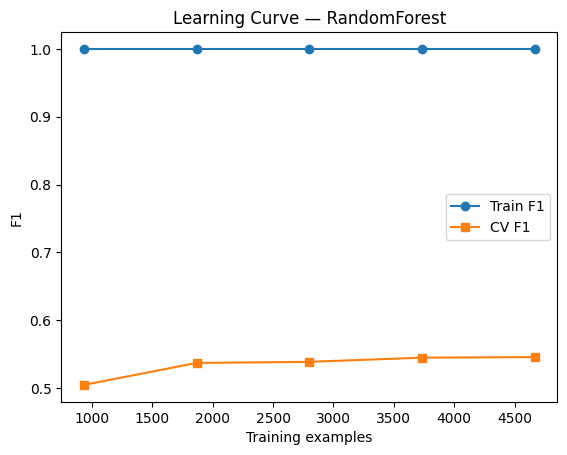

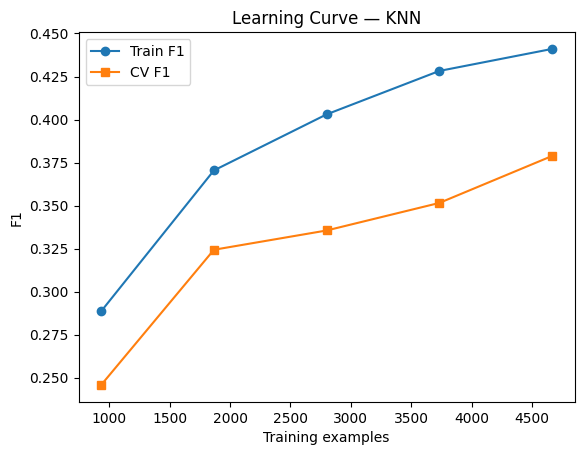

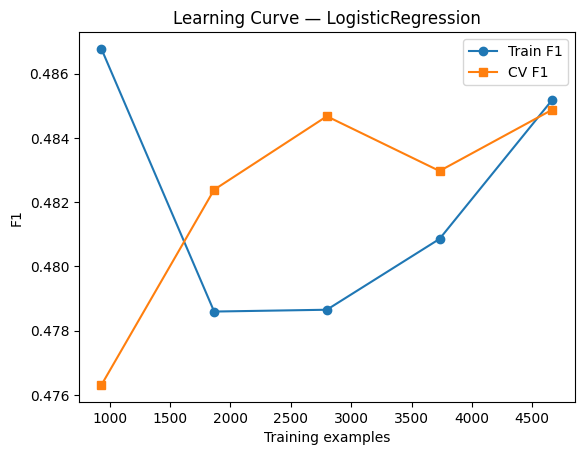

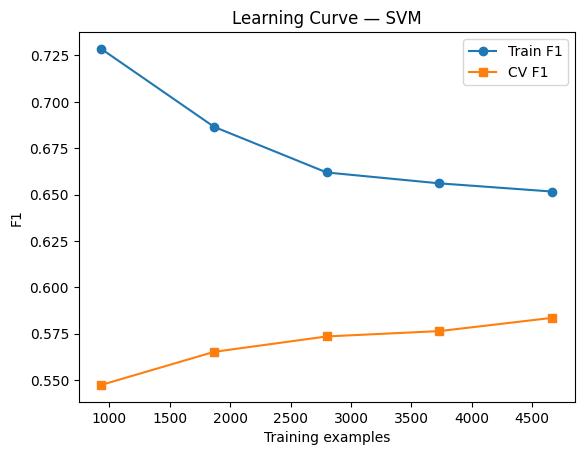

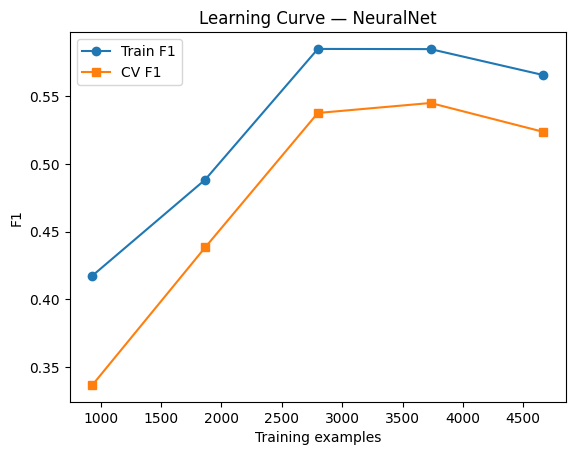

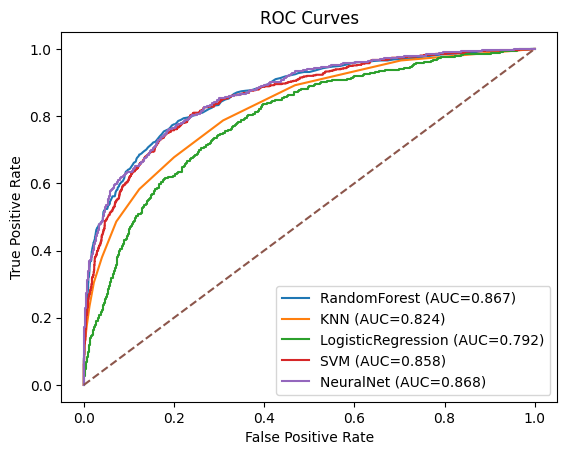

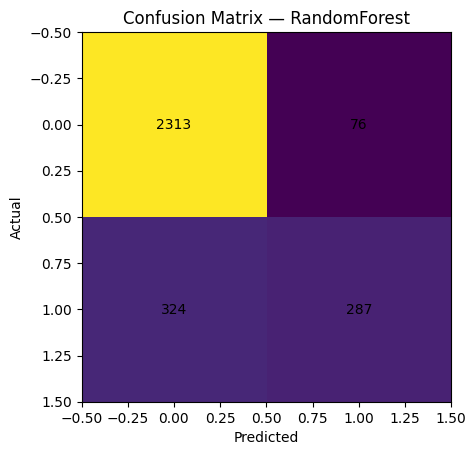

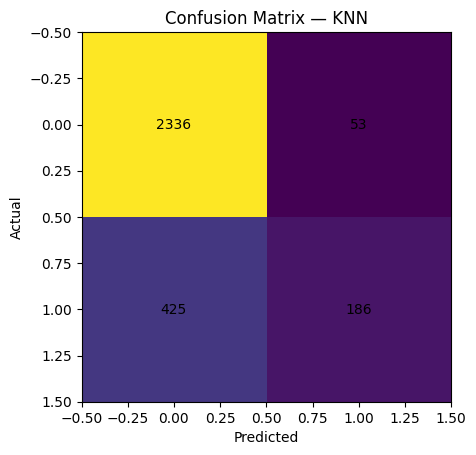

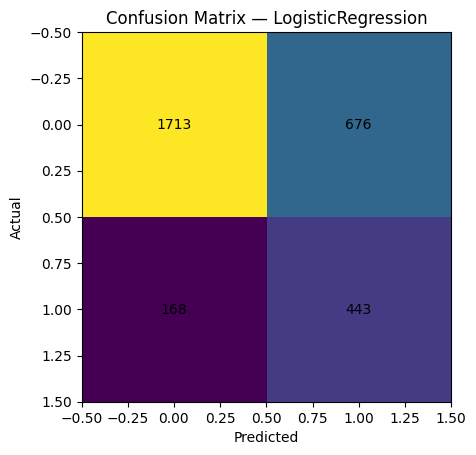

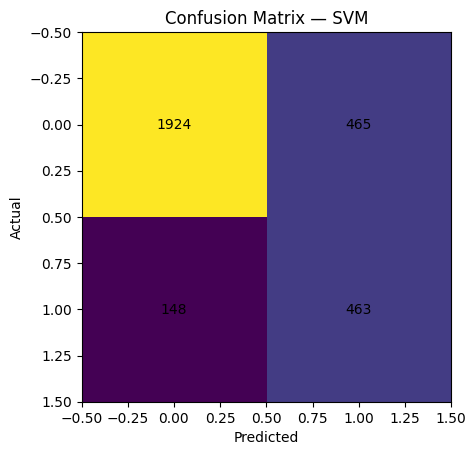

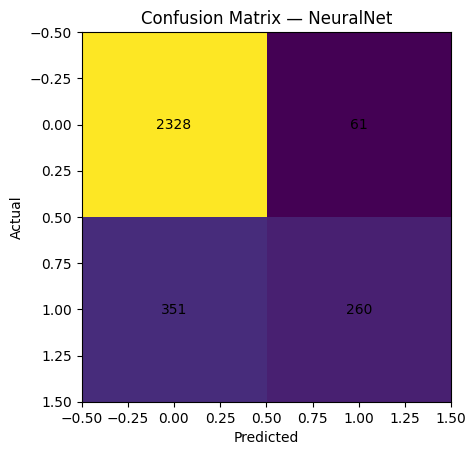

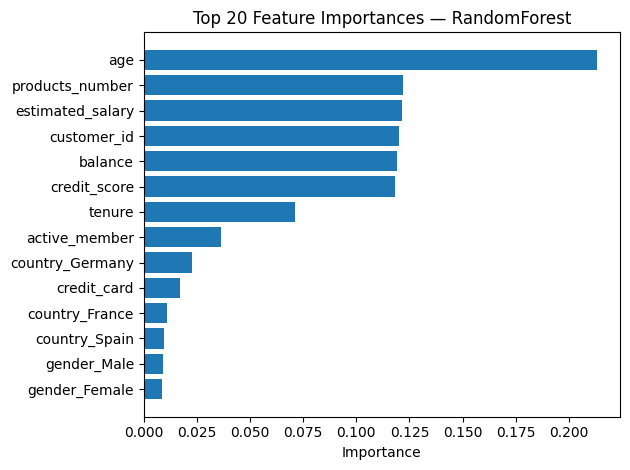

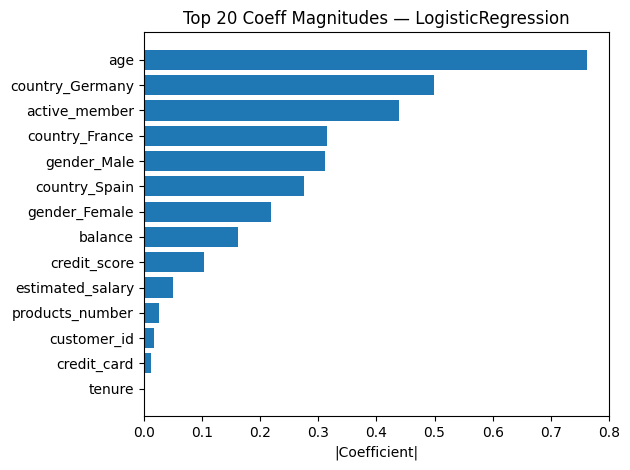

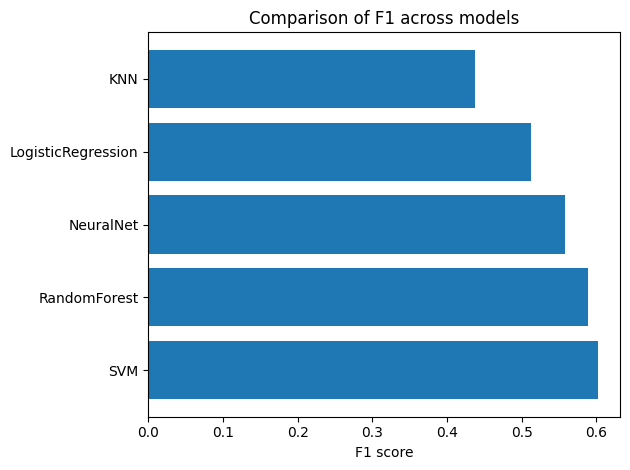

In [7]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# (a) learning curve

for name, pipe in fitted.items():
    plt.figure()
    train_sizes, train_scores, valid_scores = learning_curve(
        pipe, X_train, y_train, cv=3, scoring="f1", n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42
    )
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train F1")
    plt.plot(train_sizes, valid_scores.mean(axis=1), marker="s", label="CV F1")
    plt.title(f"Learning Curve — {name}"); plt.xlabel("Training examples"); plt.ylabel("F1"); plt.legend(); plt.show()

# (b) ROC curves

plt.figure()

for name in fitted.keys():
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    from sklearn.metrics import roc_auc_score
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, probas[name]):.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(loc="lower right"); plt.show()

# (c) Confusion matrices

for name in fitted.keys():
    cm = conf_mats[name]
    plt.figure(); plt.imshow(cm, interpolation="nearest"); plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center")
    plt.show()

# (d) Feature importance / coefficients where applicable

def get_feature_names(column_transformer):
    output_features = []
    for name, trans, cols in column_transformer.transformers_:
        if name == "remainder": continue
        if hasattr(trans, "named_steps"):
            
            last = trans.named_steps.get("onehot", None)
            if last is not None and hasattr(last, "get_feature_names_out"):
                output_features.extend(last.get_feature_names_out(cols).tolist()); continue
            last_num = trans.named_steps.get("scaler", None)
            if last_num is not None:
                output_features.extend(cols); continue
        if isinstance(cols, (list, tuple)):
            output_features.extend(cols)
    return output_features

feature_names = get_feature_names(fitted[list(fitted.keys())[0]].named_steps["preprocess"])

# RandomForest importances

if "RandomForest" in fitted:
    rf = fitted["RandomForest"].named_steps["model"]
    if hasattr(rf, "feature_importances_"):
        importances = rf.feature_importances_
        idx = np.argsort(importances)[-20:]
        plt.figure(); plt.barh(range(len(idx)), importances[idx])
        plt.yticks(range(len(idx)), [feature_names[i] if i < len(feature_names) else f"f_{i}" for i in idx])
        plt.title("Top 20 Feature Importances — RandomForest"); plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# Logistic Regression coefficients

if "LogisticRegression" in fitted:
    lr = fitted["LogisticRegression"].named_steps["model"]
    if hasattr(lr, "coef_"):
        coefs = np.abs(lr.coef_).ravel()
        idx = np.argsort(coefs)[-20:]
        plt.figure(); plt.barh(range(len(idx)), coefs[idx])
        plt.yticks(range(len(idx)), [feature_names[i] if i < len(feature_names) else f"f_{i}" for i in idx])
        plt.title("Top 20 Coeff Magnitudes — LogisticRegression"); plt.xlabel("|Coefficient|"); plt.tight_layout(); plt.show()

# (e) Horizontal bar plot comparing F1 across models

plt.figure()
# Execute the following line to carry out its operation in the workflow
plt.barh(results_df.index.tolist(), results_df["f1"].values)
# Configure labels, titles, legends, or axis properties of the plot
plt.xlabel("F1 score"); plt.title("Comparison of F1 across models"); plt.tight_layout(); plt.show()


## Part 7 — Save predictions and comparison table 

- Predict class membership probabilities for the given samples 
- Save a copy of the training dataset and the test dataset

In [8]:
pred_col = "Predicted_" + TARGET
proba_col = "Predicted_Proba_" + TARGET

best = fitted[best_model_name]

best_pred = best.predict(X_test); best_proba = best.predict_proba(X_test)[:,1]

test_out = churn_test.copy()
test_out[pred_col] = best_pred; test_out[proba_col] = best_proba

train_path = "churn_train.csv"; test_path = "churn_test.csv"
churn_train.to_csv(train_path, index=False); test_out.to_csv(test_path, index=False)
print(f"Saved: {train_path} and {test_path}")

import pandas as pd
comp_table = pd.DataFrame([
    {"Algorithm":"Random Forest","Strengths":"Handles nonlinearity; robust; mixed types; feature importance.",
     "Weaknesses":"Less interpretable; heavier compute.","Best Use Cases":"Bank churn; credit-risk screening; propensity modeling"},
    {"Algorithm":"k-Nearest Neighbors","Strengths":"Simple; non-parametric; intuitive.",
     "Weaknesses":"Sensitive to scaling; slow inference; high-dim issues.","Best Use Cases":"Bank churn; similarity recommendation; anomaly baselines"},
    {"Algorithm":"Logistic Regression","Strengths":"Interpretable; fast; calibrated probabilities.",
     "Weaknesses":"Linear boundary; needs feature engineering.","Best Use Cases":"Bank churn; marketing response; A/B outcomes"},
    {"Algorithm":"SVM (RBF)","Strengths":"Powerful nonlinear boundaries; effective in high-dim.",
     "Weaknesses":"Needs tuning; slower with probabilities.","Best Use Cases":"Bank churn; text classification; small/medium images"},
    {"Algorithm":"Neural Network (MLP)","Strengths":"Flexible; captures complex interactions.",
     "Weaknesses":"Needs tuning; less interpretable; more data/compute.","Best Use Cases":"Bank churn; cross-sell propensity; sensor/event classification"},
])
display(comp_table)


Saved: churn_train.csv and churn_test.csv


,Algorithm,Strengths,Weaknesses,Best Use Cases
0,Random Forest,Handles nonlinearity; robust; mixed types; fea...,Less interpretable; heavier compute.,Bank churn; credit-risk screening; propensity ...
1,k-Nearest Neighbors,Simple; non-parametric; intuitive.,Sensitive to scaling; slow inference; high-dim...,Bank churn; similarity recommendation; anomaly...
2,Logistic Regression,Interpretable; fast; calibrated probabilities.,Linear boundary; needs feature engineering.,Bank churn; marketing response; A/B outcomes
3,SVM (RBF),Powerful nonlinear boundaries; effective in hi...,Needs tuning; slower with probabilities.,Bank churn; text classification; small/medium ...
4,Neural Network (MLP),Flexible; captures complex interactions.,Needs tuning; less interpretable; more data/co...,Bank churn; cross-sell propensity; sensor/even...



# Part 8 — Summary & Discussion

Loaded `BankChurn.csv`, performed EDA, built preprocessing (impute+scale numeric; impute+one-hot categorical), executed a **70/30** stratified split, and trained five families of classifiers: **RandomForest**, **KNN**, **LogisticRegression**, **SVM (RBF)**, and an **MLP** with early stopping to avoid convergence warnings.  
We evaluated with **Accuracy, Precision, Recall, F1, ROC-AUC**, plotted learning curves, ROC curves, confusion matrices, feature importances/coefficients, and compared **F1** across models.

**Winner & rationale.** Check `results_df`. In many tabular churn problems, **RandomForest** or **gradient boosting** variants tend to win due to nonlinearity and interaction handling. **Logistic Regression** can be competitive on near-linear problems with good regularization. **SVM** benefits from careful tuning; **KNN** can falter in high-dim spaces; **MLP** can excel with sufficient data and tuning—early stopping helps.

**Theory vs. practice.** Observed differences align with the **bias–variance trade-off** and assumptions about linearity vs. nonlinearity, curse of dimensionality (KNN), and probability calibration (linear models often calibrate better without extra steps).

**Possible Next steps.** Hyperparameter tuning, class-imbalance remedies (class weights, resampling, thresholding), and trying **XGBoost/LightGBM/CatBoost** for stronger tabular baselines.
